### Import necessary libraries

In [13]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error

### Load csv files (colab or local jupyter notebook)

In [14]:
folder_path = 'stock-price-dataset'

csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

### Segmentation of companies stocks into highly volatile, low, and stable nature

In [15]:
def classify_stocks(file_name):
    file_path = os.path.join(folder_path, file_name)
    data = pd.read_csv(file_path)
    data['Returns'] = data['Close'].pct_change()
    data['Annualized Volatility'] = data['Returns'].std() * np.sqrt(252)
    return data['Annualized Volatility'].iloc[-1]

In [16]:
volatilities = {name: classify_stocks(name) for name in csv_files}

vol_df = pd.DataFrame.from_dict(volatilities, orient='index', columns=['Volatility'])

In [17]:
vol_df.head()

,Volatility
A.csv,0.418952
AAL.csv,0.665843
AAPL.csv,0.446056
ABBV.csv,0.267729
ABNB.csv,0.544435


In [18]:
# Thresholds based on percentiles
high_vol_threshold = vol_df['Volatility'].quantile(0.75)
low_vol_threshold = vol_df['Volatility'].quantile(0.25)

# Classify stocks
vol_df['Category'] = pd.cut(vol_df['Volatility'], bins=[0, low_vol_threshold, high_vol_threshold, float('inf')], labels=['Low', 'Stable', 'High'])

In [19]:
vol_df

,Volatility,Category
A.csv,0.418952,Stable
AAL.csv,0.665843,High
AAPL.csv,0.446056,High
ABBV.csv,0.267729,Low
ABNB.csv,0.544435,High
...,...,...
YUM.csv,0.298404,Stable
ZBH.csv,0.281025,Low
ZBRA.csv,0.414614,Stable
ZION.csv,0.385218,Stable


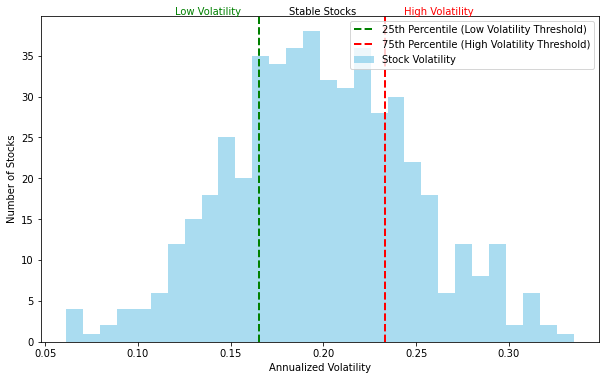

In [20]:
import matplotlib.pyplot as plt

# Simulate annualized volatility data for demonstration
np.random.seed(0)
volatility_data = np.random.normal(loc=0.2, scale=0.05, size=500)  # mean = 20%, std = 5%

# Calculate quantiles
low_vol_threshold = np.quantile(volatility_data, 0.25)
high_vol_threshold = np.quantile(volatility_data, 0.75)

# Generate histogram for visualization
plt.figure(figsize=(10, 6))
plt.hist(volatility_data, bins=30, color='skyblue', alpha=0.7, label='Stock Volatility')
plt.axvline(x=low_vol_threshold, color='green', linestyle='--', linewidth=2, label='25th Percentile (Low Volatility Threshold)')
plt.axvline(x=high_vol_threshold, color='red', linestyle='--', linewidth=2, label='75th Percentile (High Volatility Threshold)')

# Annotate regions
plt.text(low_vol_threshold - 0.01, 40, 'Low Volatility', horizontalalignment='right', color='green')
plt.text((low_vol_threshold + high_vol_threshold)/2, 40, 'Stable Stocks', horizontalalignment='center', color='black')
plt.text(high_vol_threshold + 0.01, 40, 'High Volatility', horizontalalignment='left', color='red')

plt.xlabel('Annualized Volatility')
plt.ylabel('Number of Stocks')
plt.legend()
plt.show()


### Correlation Analysis

            Open      High       Low    Volume     Close
Open    1.000000  0.999785  0.999794 -0.380518  0.999619
High    0.999785  1.000000  0.999656 -0.377726  0.999814
Low     0.999794  0.999656  1.000000 -0.383628  0.999793
Volume -0.380518 -0.377726 -0.383628  1.000000 -0.380834
Close   0.999619  0.999814  0.999793 -0.380834  1.000000


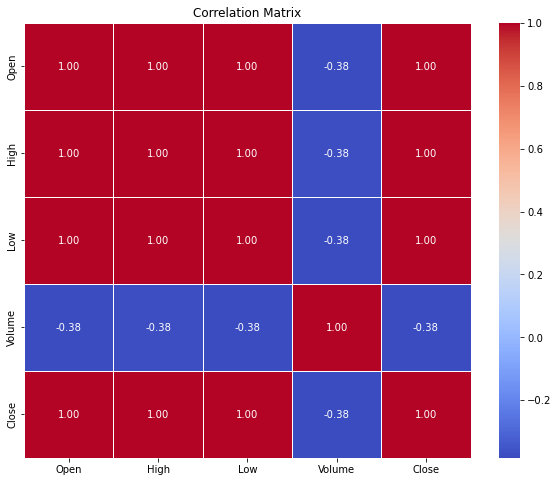

In [21]:
file_path = os.path.join(folder_path, csv_files[0])
data = pd.read_csv(file_path)

# Calculate correlation matrix
correlation_matrix = data[['Open', 'High', 'Low', 'Volume', 'Close']].corr()

# Display the correlation matrix
print(correlation_matrix)

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()


### Dataset Preparation for the LSTM network

In [22]:
import pandas_ta as ta
from sklearn.preprocessing import MinMaxScaler

### Generate sequenced data

In [113]:
def prepare_lstm_data(data, window_size):
    X, y = [], []
    feature_indices = list(range(0, data.shape[1] - 1))
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size, feature_indices])
        y.append(data[i + window_size, -1])
    return np.array(X), np.array(y)

In [114]:
scaler = MinMaxScaler()

### Adding technical indicators useful for more accurate stock prediction

In [115]:
def prepare_category_data(category_files, window_size=30):
    company_data = []
    for file_name in category_files:
        file_path = os.path.join(folder_path, file_name)
        data = pd.read_csv(file_path)
        
        # Adding technical indicators
        data['RSI'] = ta.rsi(data.Close, length=15)
        data['EMAF'] = ta.ema(data.Close, length=20)
        data['EMAM'] = ta.ema(data.Close, length=100)
        data['EMAS'] = ta.ema(data.Close, length=150)

        # Adding target column
        data['TargetNextClose'] = data['Close'].shift(-1)

        data.dropna(inplace=True)
        data.drop(['Date', 'Volume', 'Dividends', 'Stock Splits'], axis=1, inplace=True)
        
        if(data.size>0):
            scaled_data = scaler.fit_transform(data)
            X, y = prepare_lstm_data(scaled_data, window_size)
            company_data.append((X, y))
    
    return company_data


In [116]:
low_vol_files = vol_df[vol_df['Category'] == 'Low'].index.tolist()
stable_files = vol_df[vol_df['Category'] == 'Stable'].index.tolist()
high_vol_files = vol_df[vol_df['Category'] == 'High'].index.tolist()
vol_df[vol_df['Category']=='Low'].head()

,Volatility,Category
ABBV.csv,0.267729,Low
ABT.csv,0.255564,Low
ADP.csv,0.262748,Low
AEE.csv,0.216175,Low
AEP.csv,0.208099,Low


In [117]:
company_data_low = prepare_category_data(low_vol_files, window_size=30)
company_data_stable = prepare_category_data(stable_files, window_size=30)
company_data_high = prepare_category_data(high_vol_files, window_size=30)

In [118]:
print(f"Low Volatility Data: size={len(company_data_low)}")
print(f"Stable Volatility Data: size={len(company_data_stable)}")
print(f"High Volatility Data: size={len(company_data_high)}")

Low Volatility Data: size=125
Stable Volatility Data: size=251
High Volatility Data: size=126


### Building LSTM network

In [120]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import mean_squared_error
import numpy as np
import os

### Using Cuda 10.1 and torch 1.8.1+cu101 version for training

In [121]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


### Hyperparameters of the model

In [200]:
input_dim = 8
hidden_dim = 64
output_dim = 1
num_layers = 2
dropout = 0.5
batch_size = 32
num_epochs = 50
learning_rate = 0.001

### Split the data into train and test

In [201]:
def create_company_dataloaders(company_data, batch_size, train_split=0.7):
    train_loaders = []
    test_loaders = []

    for X, y in company_data:
        dataset_size = len(X)
        train_size = int(train_split * dataset_size)
        test_size = dataset_size - train_size

        X_train, X_test = X[:train_size], X[train_size:]
        y_train, y_test = y[:train_size], y[train_size:]

        train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
        test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        
        train_loaders.append(train_loader)
        test_loaders.append(test_loader)
    
    return train_loaders, test_loaders

In [202]:
train_loaders_low, test_loaders_low = create_company_dataloaders(company_data_low, batch_size)
train_loaders_stable, test_loaders_stable = create_company_dataloaders(company_data_stable, batch_size)
train_loaders_high, test_loaders_high = create_company_dataloaders(company_data_high, batch_size)

### LSTM Model Architecture

In [203]:
class StockLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout):
        super(StockLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [204]:
model = StockLSTM(input_dim, hidden_dim, output_dim, num_layers, dropout).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

### Evaluator function (testing of the model)

In [205]:
# Evaluate the model
def evaluate_model(model, test_loaders, criterion, tolerance):
    model.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0
    predictions, actuals = [], []
        
    with torch.no_grad():
        for test_loader in test_loaders:
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch.unsqueeze(1))
                test_loss += loss.item()

                # Calculate test accuracy
                test_total += y_batch.size(0)
                test_correct += (torch.abs(outputs - y_batch.unsqueeze(1)) < tolerance).sum().item()
                
                predictions.append(outputs.cpu().numpy())
                actuals.append(y_batch.cpu().numpy())
    
    test_loss /= sum(len(loader.dataset) for loader in test_loaders)
    test_accuracy = 100 * test_correct / test_total
    predictions = np.concatenate(predictions)
    actuals = np.concatenate(actuals)
    mse = mean_squared_error(actuals, predictions)
    mae = mean_absolute_error(actuals, predictions)
    rmse = np.sqrt(mse)
    return test_loss, test_accuracy, mae, mse, rmse, predictions, actuals


### Training function (train the model)

In [206]:
# Train the model
def train_model(model, train_loaders, test_loaders, criterion, optimizer, scheduler, num_epochs, patience=5, tolerance=0.01):
    model.train()
    best_loss = float('inf')
    epochs_no_improve = 0
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(num_epochs):
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for train_loader in train_loaders:
            model.train()
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch.unsqueeze(1))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

                # Calculate train accuracy
                train_total += y_batch.size(0)
                train_correct += (torch.abs(outputs - y_batch.unsqueeze(1)) < tolerance).sum().item()
        
        train_loss /= len(train_loader)
        train_accuracy = 100 * train_correct / train_total
        
        test_loss, test_accuracy, mae, mse, rmse, _, _ = evaluate_model(model, test_loaders, criterion, 0.1)
        
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Train Accuracy: {train_accuracy:.2f}%, Test Loss: {test_loss}, Test Accuracy: {test_accuracy:.2f}%')
        print(f'MAE: {mae}, MSE: {mse}, RMSE: {rmse}')
        
        scheduler.step(test_loss)

        # Early stopping
        if test_loss < best_loss:
            best_loss = test_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break
    return train_losses, test_losses, train_accuracies, test_accuracies


In [207]:
def train_and_save_model(train_loader, test_loader, model, criterion, optimizer, scheduler, num_epochs, file_path):
    print(f"Training model on {file_path.split('/')[-1].split('_')[0]} volatility data...")
    train_losses, test_losses, train_accuracies, test_accuracies = train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs)
    print(f"Evaluating model on {file_path.split('/')[-1].split('_')[0]} volatility data...")
    test_loss, test_accuracy, mae, mse, rmse, predictions, actuals = evaluate_model(model, test_loader, criterion, 0.1)
    print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy:.2f}%")
    return predictions, actuals, train_losses, test_losses, train_accuracies, test_accuracies


### Low volatile data predictions

In [208]:
predictions_low, actuals_low, train_losses, test_losses, train_accuracies, test_accuracies = train_and_save_model(train_loaders_low, test_loaders_low, model, criterion, optimizer, scheduler, num_epochs, 'low_volatility_model.pth')

Training model on low volatility data...
Epoch 1/50, Train Loss: 0.03515346954396586, Train Accuracy: 91.98%, Test Loss: 0.0001273844554079491, Test Accuracy: 86.14%
MAE: 0.035238537937402725, MSE: 0.004007434938102961, RMSE: 0.06330430507659912
Epoch 2/50, Train Loss: 0.019007601356485732, Train Accuracy: 94.61%, Test Loss: 7.610713265447728e-05, Test Accuracy: 91.25%
MAE: 0.026734057813882828, MSE: 0.002391540678218007, RMSE: 0.04890337958931923
Epoch 3/50, Train Loss: 0.016153203604928574, Train Accuracy: 95.19%, Test Loss: 7.041816046593068e-05, Test Accuracy: 91.90%
MAE: 0.02628820389509201, MSE: 0.002214194042608142, RMSE: 0.04705522209405899
Epoch 4/50, Train Loss: 0.015220039809812584, Train Accuracy: 95.46%, Test Loss: 4.4726391548544535e-05, Test Accuracy: 96.37%
MAE: 0.026026969775557518, MSE: 0.0014072067569941282, RMSE: 0.037512753158807755
Epoch 5/50, Train Loss: 0.013816173393329644, Train Accuracy: 95.83%, Test Loss: 4.721126820075196e-05, Test Accuracy: 97.95%
MAE: 0.0

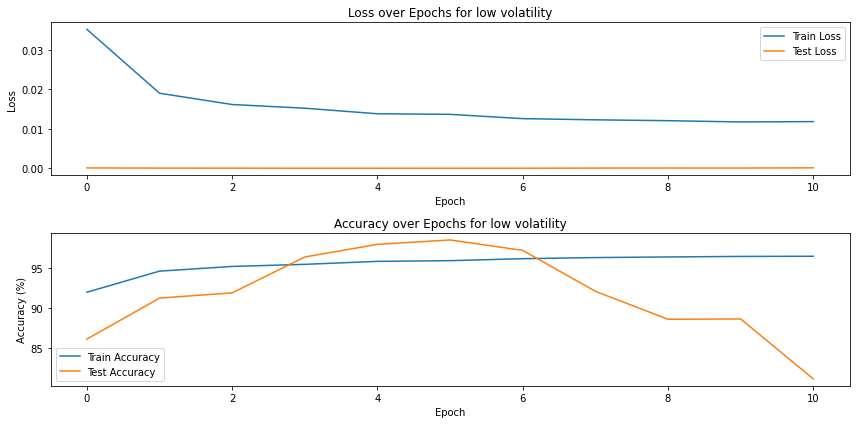

In [209]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss over Epochs for low volatility')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Accuracy over Epochs for low volatility')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

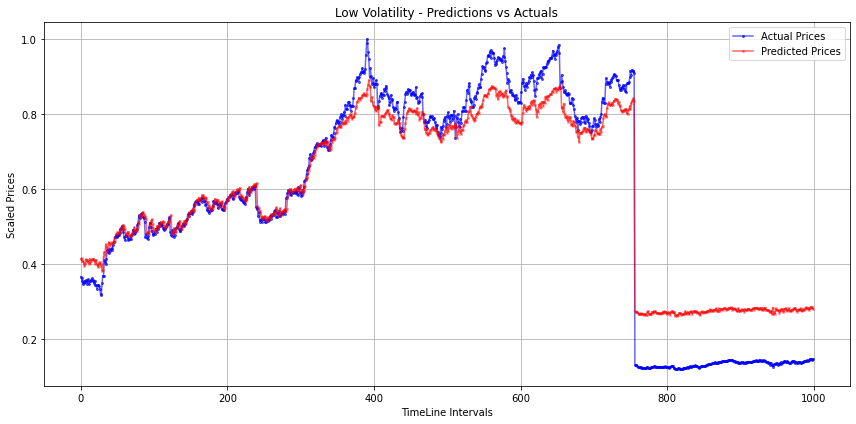

In [229]:
def plot_predictions(predictions, actuals, title, num_samples=1000):
    plt.figure(figsize=(12, 6))
    
    subset_index = min(num_samples, len(predictions))
    predictions_subset = predictions[:subset_index]
    actuals_subset = actuals[:subset_index]
    
    plt.plot(actuals_subset, label='Actual Prices', color='b', marker='o', linestyle='-', markersize=2, alpha=0.6)
    plt.plot(predictions_subset, label='Predicted Prices', color='r', marker='x', linestyle='-', markersize=2, alpha=0.6)
    
    plt.title(title)
    plt.xlabel('TimeLine Intervals')
    plt.ylabel('Scaled Prices')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_predictions(predictions_low, actuals_low, "Low Volatility - Predictions vs Actuals", num_samples=1000)


In [231]:
model.load_state_dict(torch.load('best_model.pth'))

In [211]:
def randomEvaluator(test_loader):
    model.eval()
    X_new, y_true = next(iter(test_loader))
    X_new = X_new[0].unsqueeze(0).to(device)
    y_true = y_true[0].unsqueeze(0).cpu().numpy()
    
    # Make predictions
    with torch.no_grad():
        predictions = model(X_new)
        
    predictions = predictions.cpu().numpy()
    print(f"Predictions: {predictions[0]}")
    print(f"True Values: {y_true}")

In [232]:
randomEvaluator(test_loaders_low[0])

### Stable volatile data prediction

In [ ]:
# predictions_stable, actuals_stable, train_losses, test_losses, train_accuracies, test_accuracies = train_and_save_model(train_loader_stable, test_loader_stable, model, criterion, optimizer, scheduler, num_epochs, 'stable_volatility_model.pth')

In [ ]:
# model.load_state_dict(torch.load('best_model.pth'))

### High Stable predictions

In [ ]:
# predictions_high, actuals_high, train_losses, test_losses, train_accuracies, test_accuracies = train_and_save_model(train_loader_high, test_loader_high, model, criterion, optimizer, scheduler, num_epochs, 'high_volatility_model.pth')